In [1]:
#Import necessary packages

import numpy as np
import pandas as pd
import math
import numpy.random as rand
import scipy
from scipy.stats import binom as binomial
from scipy.stats import beta as betafunction
from scipy.stats import norm
from scipy.stats import gamma
import matplotlib.pyplot as plt
from IPython.display import display
import sys
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels


In [39]:
#Load in the samples
samples = []
i = 0
burnin = 1000
for line in open('chains/BFtest/KATANGA/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

samples = np.array(samples)
print np.shape(samples)

samples = samples.astype(float)


(1489, 13)


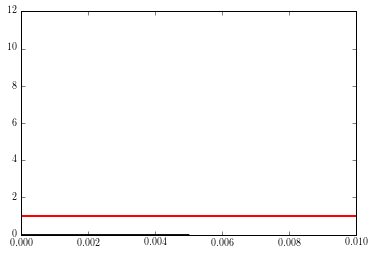

In [40]:
#Define the edges of the bins - you have to estimate the density at 'alpha=0.0,' so this will depend on bin width.
#Define them beforehand so you don't bias your results. Red line is the prior value - if the posterior is above this,
#the BF prefers the simpler model. If below, it prefers the more complicated model.
edges = np.linspace(0.,1.,200)
a,b,c = plt.hist(samples[:,8],bins=edges,normed=True)
plt.xlim(0,0.01)
plt.hlines(1,0,1.0,color='red',linewidth=2)
#plt.savefig('alphapost.png',)

In [27]:
#List of which provinces have a BF in favor of which model
cModel = ['BASCONGO','MANIEMA','KASAIOCC','KASAIOR']
wcModel = ['BANDUNDU','EQUATEUR','KATANGA','KINSHASA','ORIENTALE','SKIVU','NKIVU']